# オイル温度予測モデルの構築

### ライブラリーのインポート

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError


from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import LSTM, Dense

plt.rcParams['font.family'] = 'MS Gothic'  


In [3]:
df = pd.read_csv("ett.csv")

In [4]:
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    17420 non-null  object 
 1   HUFL    17420 non-null  float64
 2   HULL    17420 non-null  float64
 3   MUFL    17420 non-null  float64
 4   MULL    17420 non-null  float64
 5   LUFL    17420 non-null  float64
 6   LULL    17420 non-null  float64
 7   OT      17420 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.1+ MB


In [6]:
df.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,7.375141,2.242242,4.300239,0.881568,3.066062,0.856932,13.324672
std,7.067744,2.042342,6.826978,1.809293,1.164506,0.599552,8.566946
min,-22.705999,-4.756000,-25.087999,-5.934000,-1.188000,-1.371000,-4.080000
25%,5.827000,0.737000,3.296000,-0.284000,2.315000,0.670000,6.964000
50%,8.774000,2.210000,5.970000,0.959000,2.833000,0.975000,11.396000
75%,11.788000,3.684000,8.635000,2.203000,3.625000,1.218000,18.079000
max,23.643999,10.114000,17.341000,7.747000,8.498000,3.046000,46.007000


In [7]:
df.isnull().sum()

date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

In [8]:
df['date'] = pd.to_datetime(df['date']) #時間データ変換

In [9]:
X = df.drop( columns = ["OT","date"], axis = 1)
y = df[["OT"]]

目的変数のグラフの確認

<Axes: xlabel='date', ylabel='OT'>

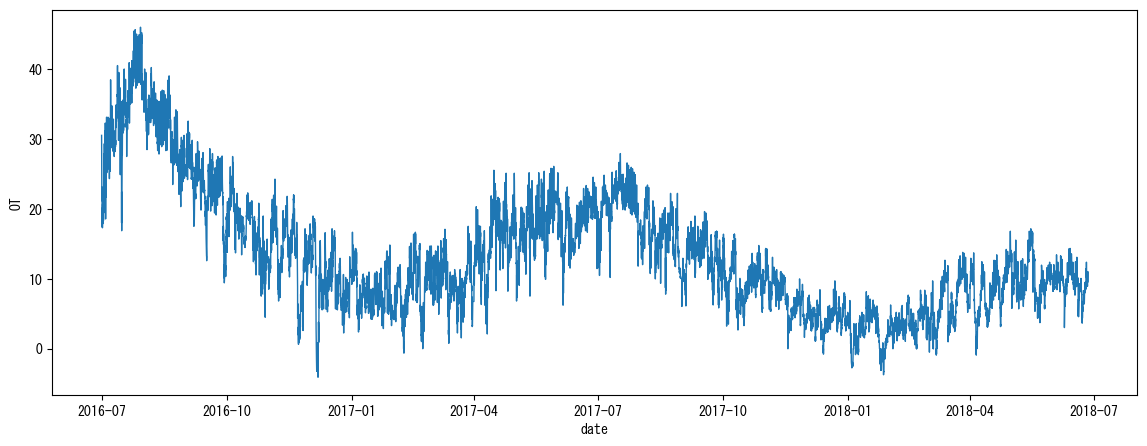

In [10]:
# snsプロット
plt.figure(figsize=(14, 5))
sns.lineplot(x="date", y="OT", data=df,  linewidth=1)

年度別に表した結果

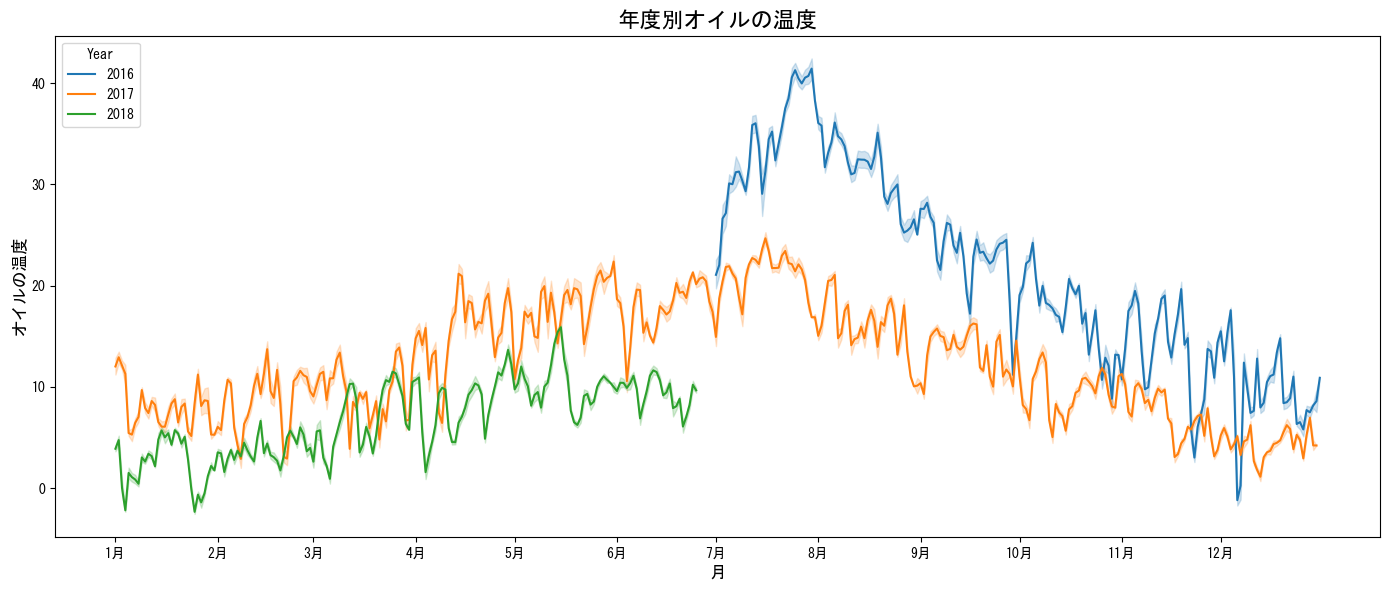

In [11]:
df_by_year = df.copy()
df_by_year["year"] = df_by_year["date"].dt.year
df_by_year["dayofyear"] = df_by_year["date"].dt.dayofyear

plt.figure(figsize=(14, 6))
sns.lineplot(x="dayofyear", y="OT", hue="year", data=df_by_year, palette="tab10")

month_start_dates = pd.date_range("2020-01-01", "2020-12-31", freq="MS")
month_ticks = month_start_dates.dayofyear
month_labels = [f"{d.month}月" for d in month_start_dates] 
plt.xticks(ticks=month_ticks, labels=month_labels)

plt.title("年度別オイルの温度", fontsize=16)
plt.xlabel("月", fontsize=12)
plt.ylabel("オイルの温度", fontsize=12)
plt.legend(title="Year", loc='upper left')
plt.tight_layout()
plt.show()


説明変数の確認

array([[<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'HUFL'}>,
        <Axes: title={'center': 'HULL'}>],
       [<Axes: title={'center': 'MUFL'}>,
        <Axes: title={'center': 'MULL'}>,
        <Axes: title={'center': 'LUFL'}>],
       [<Axes: title={'center': 'LULL'}>, <Axes: title={'center': 'OT'}>,
        <Axes: >]], dtype=object)

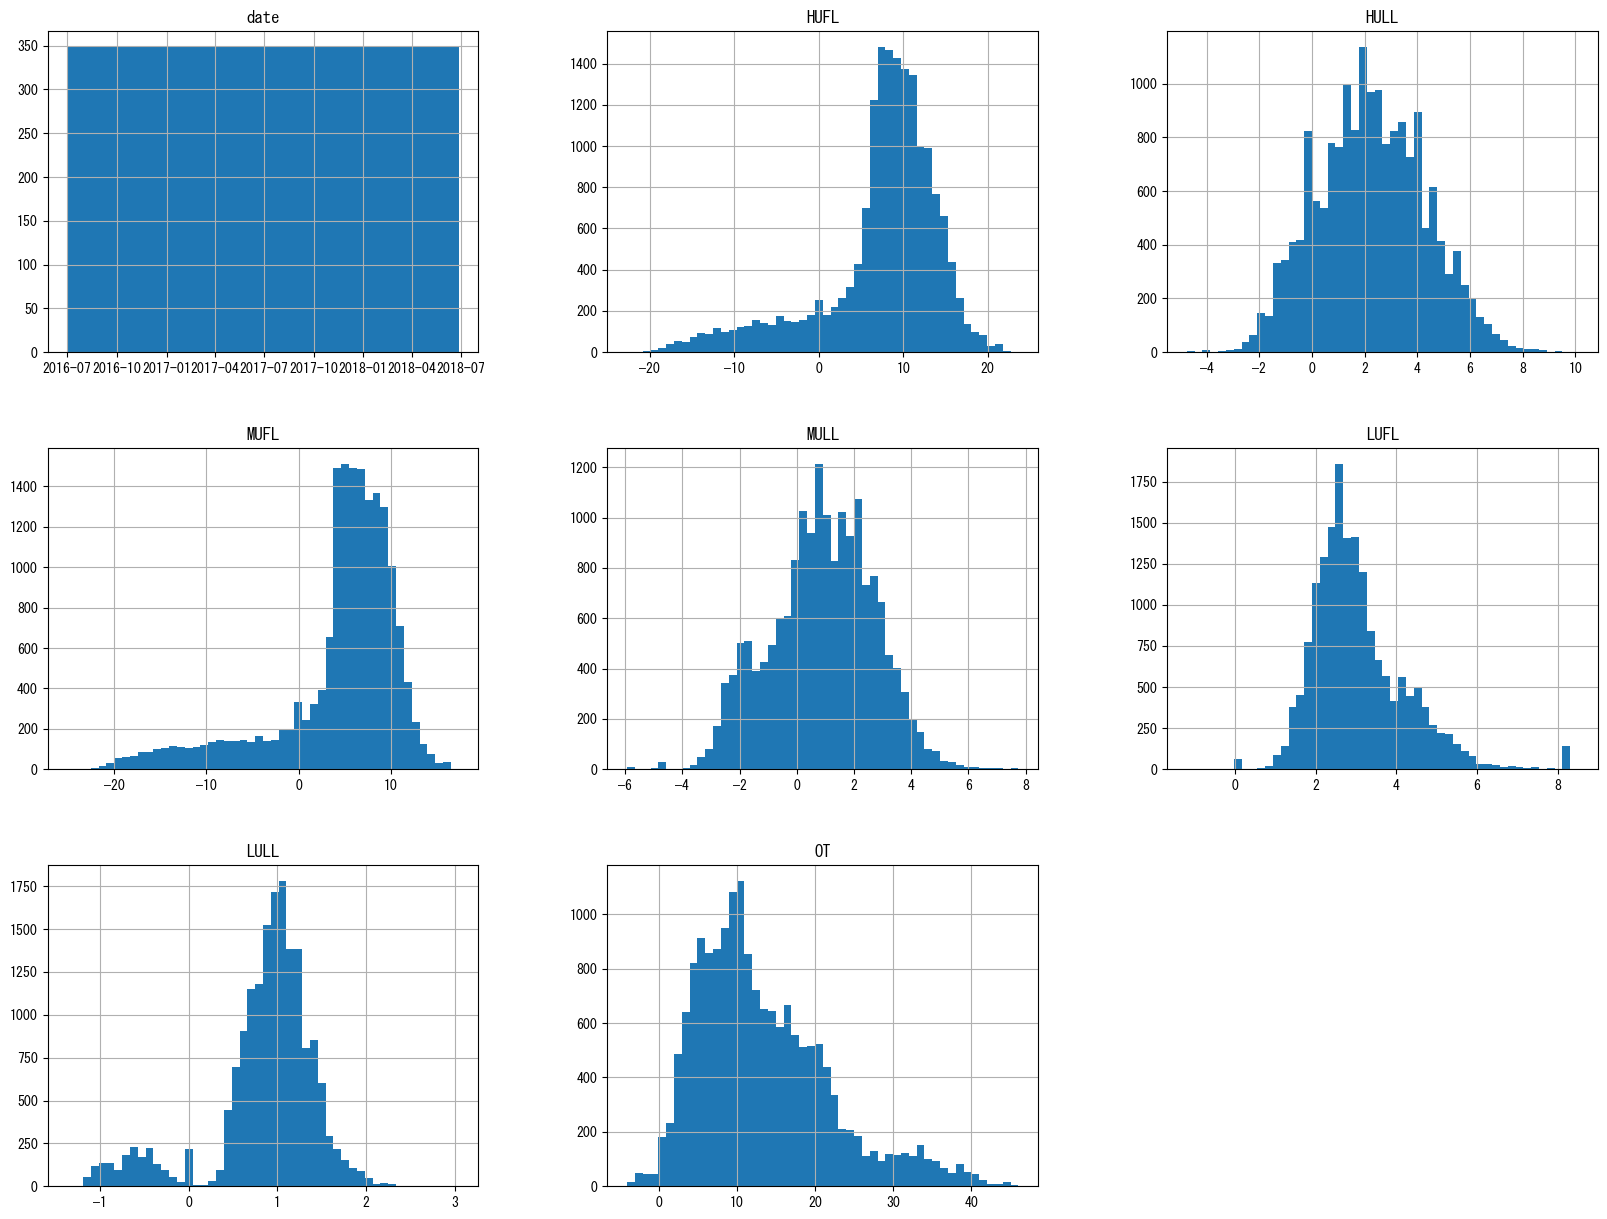

In [12]:
df.hist(bins=50,figsize=(20,15))

In [13]:
features = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]

#正規化
X_norm = MinMaxScaler().fit_transform(X)

# 標準化
X_scaled = StandardScaler().fit_transform(X_norm)

df_scaled = pd.DataFrame(X_scaled, columns=features)

# 必要なら date や OT などを追加
df_scaled["date"] = df["date"]
df_scaled["OT"] = df["OT"]

array([[<Axes: title={'center': 'HUFL'}>,
        <Axes: title={'center': 'HULL'}>,
        <Axes: title={'center': 'MUFL'}>],
       [<Axes: title={'center': 'MULL'}>,
        <Axes: title={'center': 'LUFL'}>,
        <Axes: title={'center': 'LULL'}>],
       [<Axes: title={'center': 'date'}>, <Axes: title={'center': 'OT'}>,
        <Axes: >]], dtype=object)

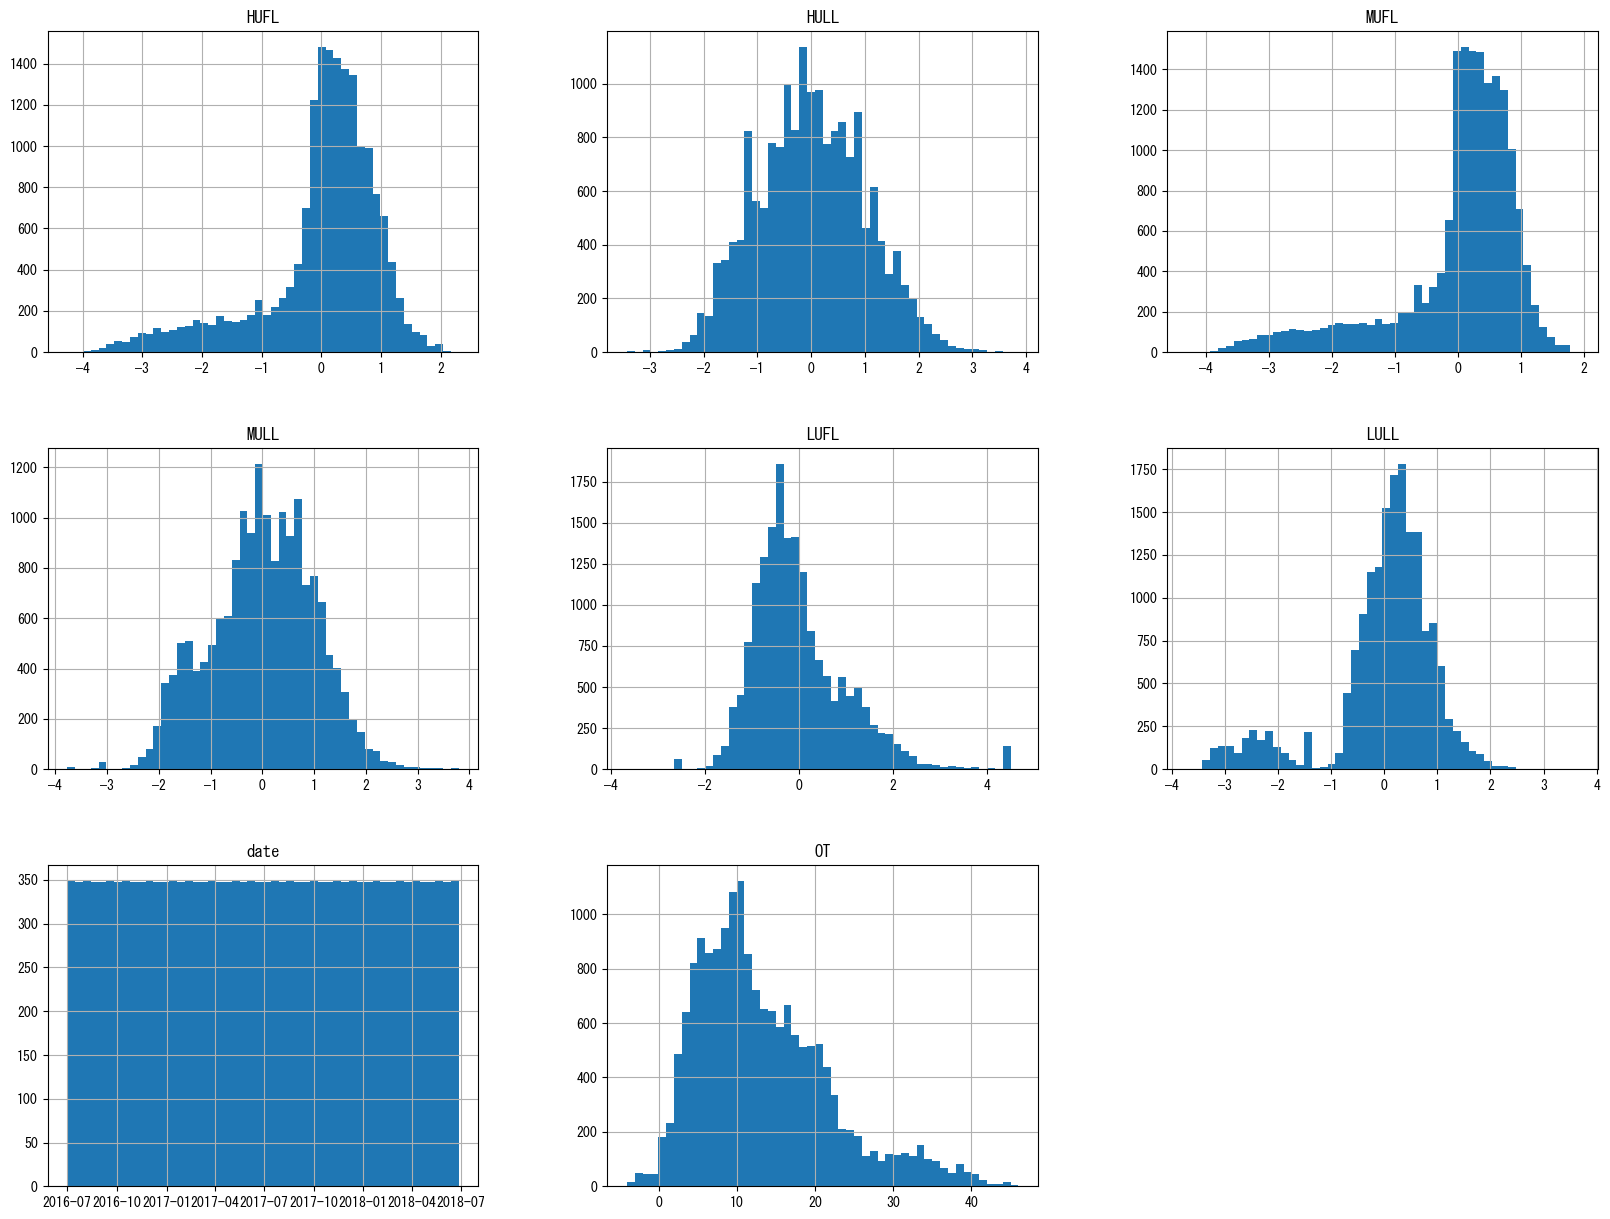

In [14]:
df_scaled.hist(bins=50,figsize=(20,15))

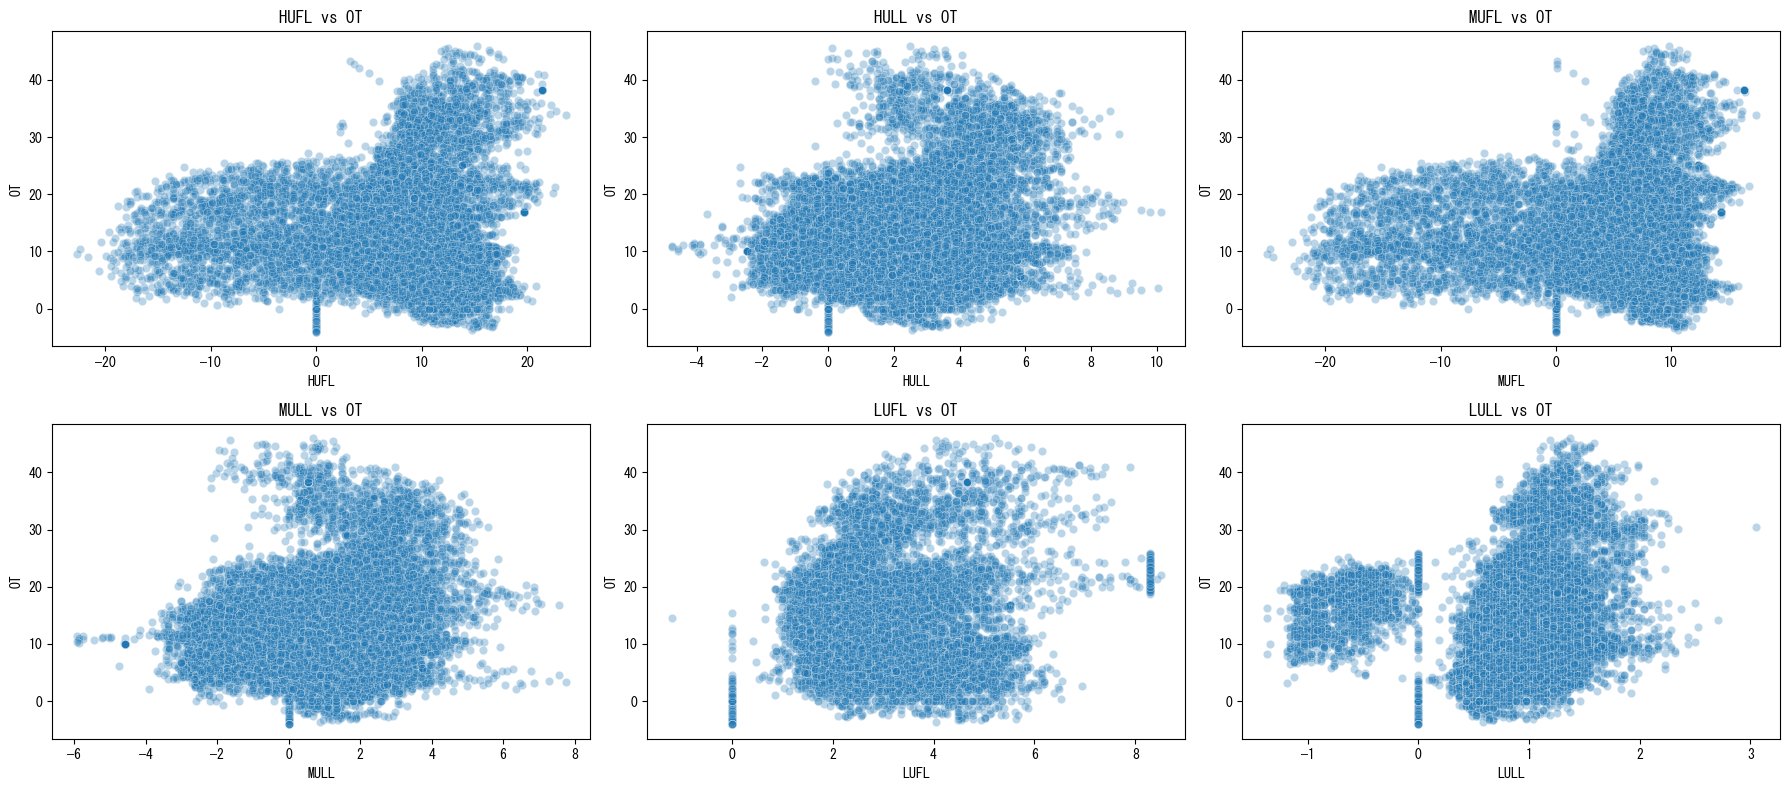

In [15]:
features = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for ax, col in zip(axes.flat, features):
    sns.scatterplot(x=col, y="OT", data=df, ax=ax, alpha=0.3)
    ax.set_title(f"{col} vs OT")

plt.tight_layout()
plt.show()


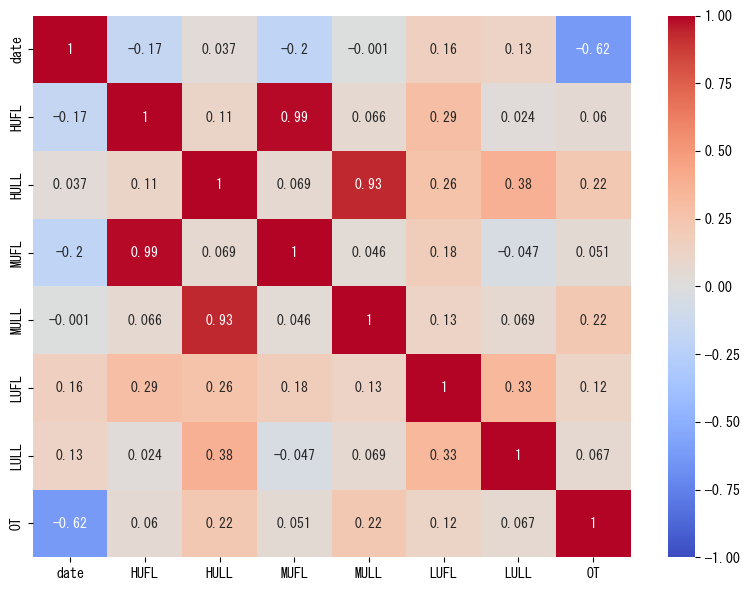

In [16]:
# 相関行列
corr_matrix = df.corr()

# ヒートマップ描画
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

## データの前処理

### 多重共線性の除去とスケーリング


多重共線性をなくし、スケーリング

In [17]:
## 多重共線性をなくしたdf

df1 = df.copy()

# NLUFL, NLULL を定義（共線性を除去）
df1["NLUFL"] = df1["HUFL"]
df1["NLULL"] = df1["HULL"]

df_replace = df1[["date", "NLUFL", "NLULL", "LUFL", "LULL", "OT"]].copy()

features_replace = ["NLUFL", "NLULL", "LUFL", "LULL"]
df_replace[features_replace] = StandardScaler().fit_transform(df_replace[features_replace])


In [18]:
## 元のdf

features_all = ["HUFL", "MUFL", "LUFL", "HULL", "MULL", "LULL"]

df_scaled = df.copy()
df_scaled[features_all] = StandardScaler().fit_transform(df_scaled[features_all])

### テストデータ分割

In [19]:
# 説明変数と目的変数 (修正なし)
X = df_scaled[["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]]
y = df_scaled["OT"]

# ランダムに8:2で分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,shuffle=False
)


In [20]:
# 説明変数と目的変数　(修正あり)
X_replace = df_replace[["NLUFL", "NLULL", "LUFL", "LULL"]]
y_replace = df_replace["OT"]

# ランダムに8:2で分割
X_train_replace, X_test_replace, y_train_replace, y_test_replace = train_test_split(
    X_replace, y_replace, test_size=0.2, random_state=42,shuffle=False
)

### RandomForesetでの予測

評価指標として、MASEを実装

In [21]:
def mase(y_true, y_pred, seasonality=1):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae_model = np.mean(np.abs(y_true - y_pred))
    
    naive_forecast = y_true[:-seasonality]
    naive_actual = y_true[seasonality:]
    
    mae_naive = np.mean(np.abs(naive_actual - naive_forecast))
    if mae_naive == 0:
        return np.nan

    return mae_model / mae_naive


RandomForestのモデルの指定・構築・評価

In [22]:
# RandomForest
model_RF = RandomForestRegressor(n_estimators=100, random_state=42)
model_RF.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [23]:
y_pred = model_RF.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
MASE = mase(y_test, y_pred, seasonality=1)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"MASE: {MASE:.4f}")
print(f"R^2: {r2}")

MAE: 6.735
MASE: 15.0280
R^2: -5.183754692402521


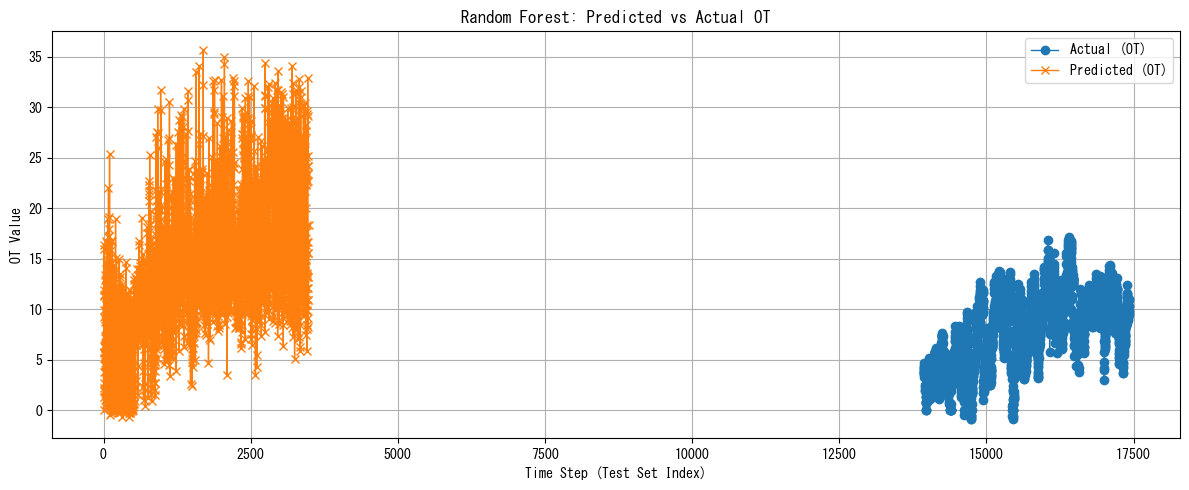

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Actual (OT)", marker="o", linewidth=1)
plt.plot(y_pred, label="Predicted (OT)", marker="x", linewidth=1)
plt.title("Random Forest: Predicted vs Actual OT")
plt.xlabel("Time Step (Test Set Index)")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# RandomForest(多重共線性の除去したデータ)
model_RF_replace = RandomForestRegressor(n_estimators=100, random_state=42)
model_RF_replace.fit(X_train_replace, y_train_replace)

y_pred_replace = model_RF_replace.predict(X_test_replace)
mae = mean_absolute_error(y_test_replace, y_pred_replace)
MASE = mase(y_test_replace, y_pred_replace, seasonality=1)
r2 = r2_score(y_test_replace, y_pred_replace)

print(f"MAE: {mae:.3f}")
print(f"MASE: {MASE:.4f}")
print(f"R^2: {r2}")

MAE: 6.754
MASE: 15.0706
R^2: -5.39813628929236


### GBoostを利用した予測

XGBoostのモデルの指定・構築・評価

In [26]:
# XGBoostモデル
model_XG = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_XG.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [27]:
# 予測と評価
y_pred = model_XG.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
MASE = mase(y_test, y_pred, seasonality=1)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.3f}")
print(f"MASE: {MASE:.4f}")
print(f"R^2  : {r2:.3f}")


MAE : 6.285
MASE: 14.0234
R^2  : -4.434


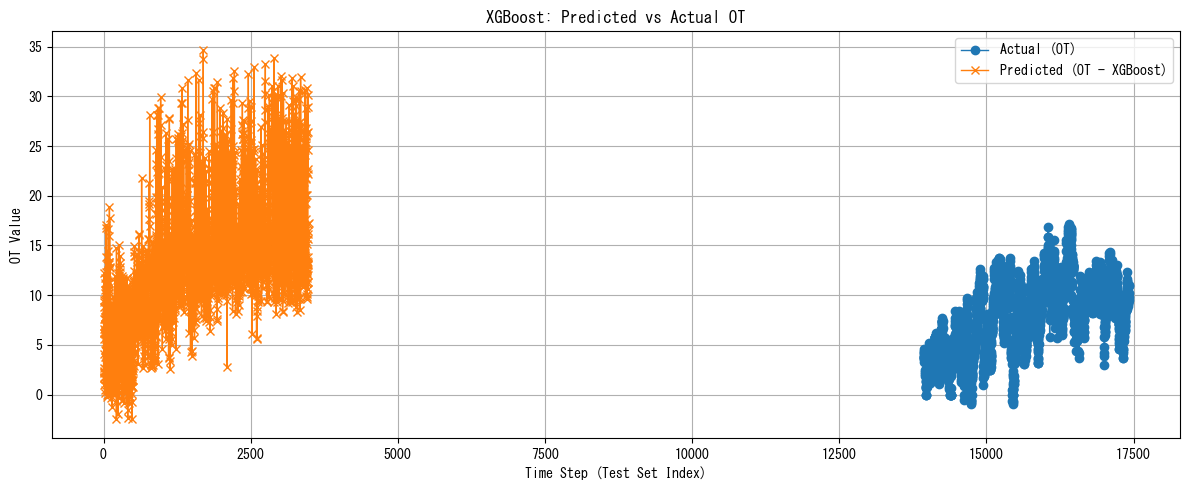

In [28]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Actual (OT)", marker='o', linewidth=1)
plt.plot(y_pred, label="Predicted (OT - XGBoost)", marker='x', linewidth=1)
plt.title("XGBoost: Predicted vs Actual OT")
plt.xlabel("Time Step (Test Set Index)")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# XGBoostモデル(多重共線性の除去したデータ)
model_XG_replace = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_XG_replace.fit(X_train_replace, y_train_replace)

# 予測と評価
y_pred_replace = model_XG_replace.predict(X_test_replace)
mae = mean_absolute_error(y_test_replace, y_pred_replace)
MASE = mase(y_test_replace, y_pred_replace, seasonality=1)
r2 = r2_score(y_test_replace, y_pred_replace)

print(f"MAE : {mae:.3f}")
print(f"MASE: {MASE:.4f}")
print(f"R^2  : {r2:.3f}")


MAE : 6.423
MASE: 14.3313
R^2  : -4.793


### RNN

RNNモデルの指定・構築・評価

多重共線性をなくしたデータ

In [30]:
# データシーケンスの作成
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i, -1])  # OTは最後の列
    return np.array(X), np.array(y)


features_reduced = ["NLUFL", "NLULL", "LUFL", "LULL", "OT"]
scaled_reduced = df_replace[features_reduced].values
X_reduced, y_reduced = create_sequences(scaled_reduced, time_steps=10)

ot_scaler_reduced = MinMaxScaler().fit(df[["OT"]])

# --- モデル構築・学習・評価 ---
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.2, shuffle=False)

model_reduced = Sequential()
model_reduced.add(SimpleRNN(64, activation="tanh", input_shape=(X_train.shape[1], X_train.shape[2])))
model_reduced.add(Dense(1))
model_reduced.compile(optimizer="adam", loss="mse")

model_reduced.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

y_pred = model_reduced.predict(X_test)
y_test_inv = ot_scaler_reduced.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = ot_scaler_reduced.inverse_transform(y_pred)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
MASE = mase(y_test_inv, y_pred_inv, seasonality=1)
r2 = r2_score(y_test_inv, y_pred_inv)

print("共線性なし（df_replace）")
print(f"MAE : {mae:.3f}, MASE : {MASE:.3f}, R² : {r2:.3f}")


Epoch 1/10


C:\Users\xpfks\py3.11env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 161.8689 - val_loss: 1.9052
Epoch 2/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 16.5725 - val_loss: 2.4376
Epoch 3/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 6.1875 - val_loss: 3.3717
Epoch 4/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 2.9320 - val_loss: 2.9633
Epoch 5/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 1.8604 - val_loss: 3.1878
Epoch 6/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 1.4361 - val_loss: 3.3161
Epoch 7/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 1.2282 - val_loss: 2.9623
Epoch 8/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 1.1544 - val_loss: 2.8918
Epoch 9/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 1.0741 - val_loss: 2.4904
Epoch 10/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.0088 - val_loss: 3.5726
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
共線性なし（df_replace）
MAE : 26.685, MASE : 1.188, R² : 0.938


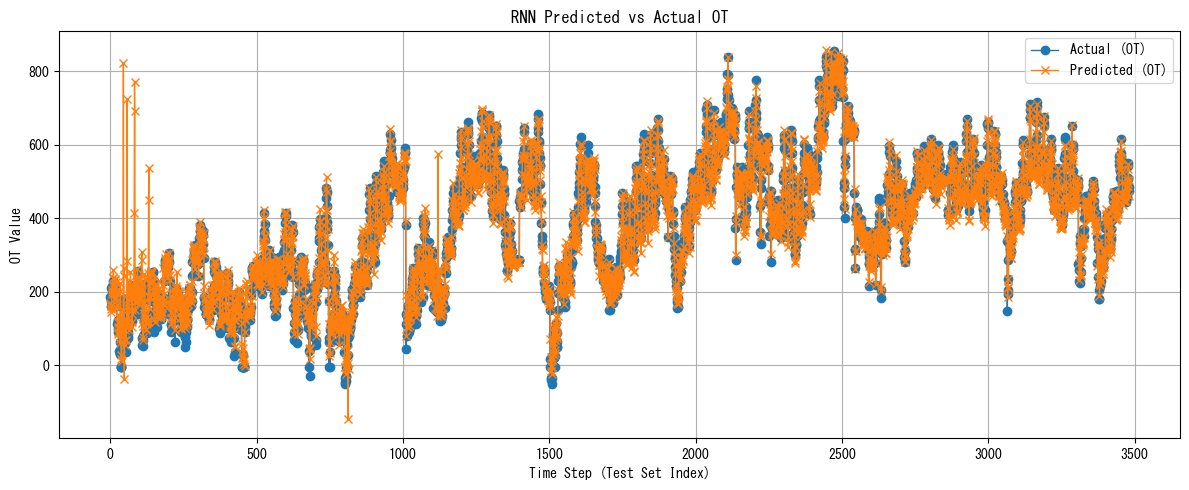

In [31]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label="Actual (OT)", marker="o", linewidth=1)
plt.plot(y_pred_inv, label="Predicted (OT)", marker="x", linewidth=1)
plt.title("RNN Predicted vs Actual OT")
plt.xlabel("Time Step (Test Set Index)")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


元のデータ

In [32]:
# --- データ準備（共線性あり） ---
features_full = ["HUFL", "MUFL", "LUFL", "HULL", "MULL", "LULL", "OT"]
scaled_full = df_scaled[features_full].values
X_full, y_full = create_sequences(scaled_full, time_steps=10)

# OT用スケーラー（同じくdfから）
ot_scaler_full = MinMaxScaler().fit(df[["OT"]])

# --- モデル構築・学習・評価 ---
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, shuffle=False)

model_scaled = Sequential()
model_scaled.add(SimpleRNN(64, activation="tanh", input_shape=(X_train.shape[1], X_train.shape[2])))
model_scaled.add(Dense(1))
model_scaled.compile(optimizer="adam", loss="mse")

model_scaled.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

y_pred = model_scaled.predict(X_test)
y_test_inv = ot_scaler_full.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = ot_scaler_full.inverse_transform(y_pred)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
MASE = mase(y_test_inv, y_pred_inv, seasonality=1)
r2 = r2_score(y_test_inv, y_pred_inv)

print("共線性あり（df_scaled）")
print(f"MAE : {mae:.3f}, MASE : {MASE:.3f}, R² : {r2:.3f}")


Epoch 1/10


C:\Users\xpfks\py3.11env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 113.8443 - val_loss: 1.3209
Epoch 2/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 14.4438 - val_loss: 0.7822
Epoch 3/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 4.6032 - val_loss: 1.7947
Epoch 4/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 2.3654 - val_loss: 2.3827
Epoch 5/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 1.4774 - val_loss: 1.7928
Epoch 6/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 1.2780 - val_loss: 2.1163
Epoch 7/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 1.2000 - val_loss: 1.9287
Epoch 8/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 1.0644 - val_loss: 1.8200
Epoch 9/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 1.0698 - val_loss: 1.8012
Epoch 10/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 0.9794 - val_loss: 1.4608
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
共線性あり（df_scaled）
MAE : 24.499, MASE : 1.091, R² : 0.952


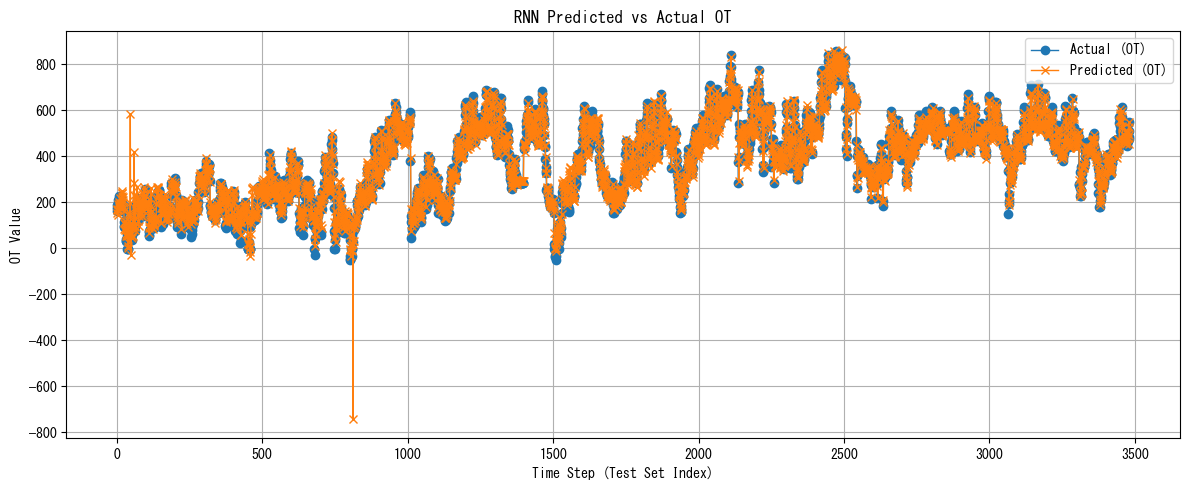

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label="Actual (OT)", marker="o", linewidth=1)
plt.plot(y_pred_inv, label="Predicted (OT)", marker="x", linewidth=1)
plt.title("RNN Predicted vs Actual OT")
plt.xlabel("Time Step (Test Set Index)")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
    

### LSTM

In [34]:
# LSTM用の前処理
df["OT"] = df["OT"].astype(float)
scaler = MinMaxScaler()
scaled_ot = scaler.fit_transform(df["OT"].values.reshape(-1, 1))


In [35]:
# 2. 時系列シーケンスの作成（例：過去10ステップで次を予測）
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_ot, time_steps=10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

In [36]:
# 4. LSTMモデル
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=64, activation="tanh", input_shape=(X_train.shape[1], X_train.shape[2])))
model_LSTM.add(Dense(1))
model_LSTM.compile(optimizer="adam", loss="mse")

model_LSTM.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


C:\Users\xpfks\py3.11env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0152 - val_loss: 5.2613e-04
Epoch 2/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012 - val_loss: 4.1096e-04
Epoch 3/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.1188e-04 - val_loss: 3.4626e-04
Epoch 4/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.7437e-04 - val_loss: 2.2359e-04
Epoch 5/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.8273e-04 - val_loss: 2.4569e-04
Epoch 6/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7700e-04 - val_loss: 1.6771e-04
Epoch 7/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0578e-04 - val_loss: 1.9560e-04
Epoch 8/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9992e-04 - val_loss: 1.5213e-04
Epoch 9/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9379e-04 - val_loss: 1.3911e-04
Epoch 10/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.6889e-04 - val_loss: 1.6489e-04


In [37]:
# 6. 評価
y_pred = model_LSTM.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
MASE = mase(y_test_inv, y_pred_inv, seasonality=1)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE : {mae:.3f}")
print(f"MASE: {MASE:.4f}")
print(f"R²  : {r2:.3f}")


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE : 0.495
MASE: 1.1035
R²  : 0.959


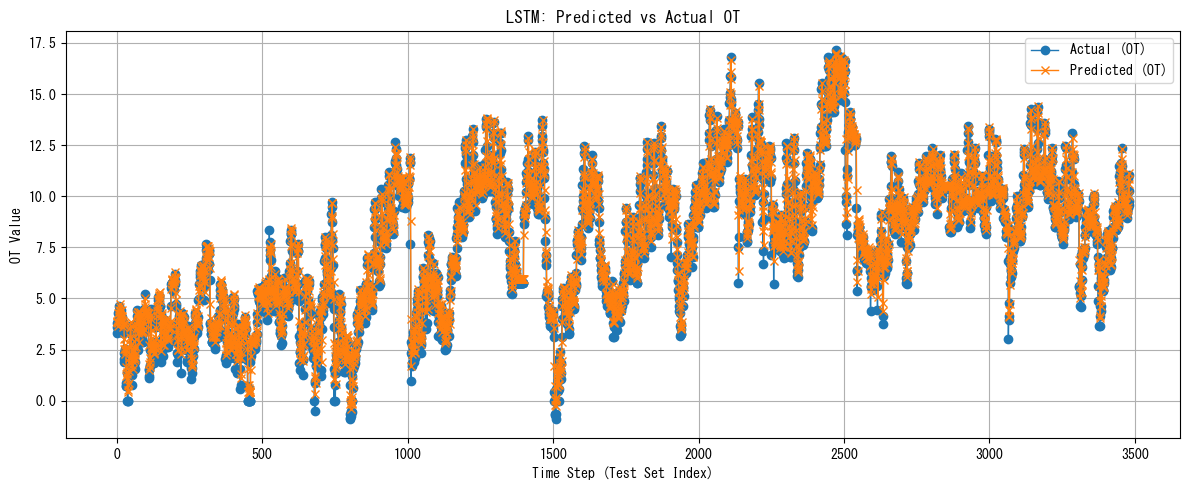

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label="Actual (OT)", marker="o", linewidth=1)
plt.plot(y_pred_inv, label="Predicted (OT)", marker="x", linewidth=1)
plt.title("LSTM: Predicted vs Actual OT")
plt.xlabel("Time Step (Test Set Index)")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
